In [1]:
#pip install emoji
#pip install autocorrect
"""
Use this cell to install any pacakges that you may need. Cell below this has import for all the modules/pacakages that
is used. So, please use command (pip) as commented above to install any packages that you need. 
"""


'\nUse this cell to install any pacakges that you may need. Cell below this has import for all the modules/pacakages that\nis used. So, please use command (pip) as commented above to install any packages that you need. \n'

In [2]:
"""
This cell is where all the pacakges required for the project is imported.  
"""

import numpy as np
import pandas as pd
from keras import Model
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, concatenate, Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, TimeDistributed, Convolution1D, MaxPooling1D, Dropout
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from autocorrect import Speller
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Using TensorFlow backend.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kripa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kripa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kripa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
"""
This cell is where I have defined some functions that will be used later for our data preperation.
--------------------------------------------------------------------------------------------------
get_hash_tags --> This function is used to get any has-tag that are part of our responce or context.
get_emoji --> This function is used to get any emoji related to the response or context that we have. 
clean_text --> This function is used to clean our input text. This will remove the junk characters, 
               remove some mentions which are not required and apply the Lemmatizer to clean those text.  
"""

lemmatizer = WordNetLemmatizer();
stemmer = PorterStemmer();
spell = Speller(lang='en');
stopword = stopwords.words('english');

def get_hash_tags(txt):
    hastags = re.findall(r"#(\w+)", txt)
    return hastags

def get_emoji(txt):
    return ' '.join(emoji.UNICODE_EMOJI[c] for c in txt if c in emoji.UNICODE_EMOJI)

def clean_text(txt):
    bef_txt = txt
    txt = txt.replace('@USER', '').lstrip().rstrip()
    txt = txt.lower()
    txt = re.sub(r"#(\w+)", "", txt)
    txt = re.sub(r"@(\w+)", "", txt)
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is",txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"i'm", "i am", txt)
    txt = re.sub(r"he's", "he is",txt)
    txt = re.sub(r"she's", "she is", txt)
    txt = re.sub(r"that's", "that is", txt)
    txt = re.sub(r"what's", "what is", txt)
    txt = re.sub(r"where's", "where is", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"\'ve", " have", txt)
    txt = re.sub(r"won't", "will not", txt)
    txt = re.sub(r"don't", "do not", txt)
    txt = re.sub(r"did't", "did not", txt)
    txt = re.sub(r"did'nt", "did not", txt)
    txt = re.sub(r"can't", "can not", txt)
    txt = re.sub(r"it's", "it is", txt)
    txt = re.sub(r"couldn't", "could not", txt)
    txt = re.sub(r"have't", "have not", txt)
    txt = re.sub('[^a-zA-z0-9\s]','',txt)
    txt = re.sub(r'\d+', '',txt)
    txt = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", txt)
    
    txt = ' '.join([y for y in txt.split() if not y in string.punctuation])
    txt = ' '.join([y for y in txt.split() if not y in stopword])
    txt = ' '.join([lemmatizer.lemmatize(y) for y in txt.split()])
    #txt = ' '.join([stemmer.stem(y) for y in txt.split()]) -- Not using stemmer for this project.
    txt = txt.lstrip().rstrip()

    return txt
    

In [4]:
"""
This cell is where we read the training data from train.jsonl
Please make sure the train.jsonl is inside the data folder , where data folder is in same folder as this source code.

Here we read the data file , apply the previous function like get_emoji, clean_text to clean-up our data for training. 
As, we are using Pandas to read our training data, we override the columns with cleaned data.
OR we are introduing new columns for the emoji related data or has-tags. 

We have differnt columns defined for response and context.
Context is treated as last element of the list while read from the file. 
"""

data = pd.read_json (r'.\data\train.jsonl',encoding='UTF-8', lines=True)
data['response_ht'] = data['response'].apply(lambda x: get_hash_tags(x))
data['response_emoji'] = data['response'].apply(lambda x: get_emoji(x))
data['response'] = data['response'].apply(lambda x: clean_text(x))

data['cntx'] = data['context'].apply(lambda x: x[len(x)-1] if (len(x) > 0) else '')
data['cntx_ht'] = data['cntx'].apply(lambda x: get_hash_tags(x))
data['cntx_emoji'] = data['cntx'].apply(lambda x: get_emoji(x))
data['cntx'] = data['cntx'].apply(lambda x: clean_text(x))

data['is_sarcastic'] = data['label'].apply(lambda x: 1 if(x == "SARCASM") else 0)

data['overall'] = data['cntx'] +" "+ data['response']
print("Training rows: ",len(data))

Training rows:  5000


In [5]:
"""
This cell is similar to cell above, in previous cell we were cleaning data and preparing data for training data-set.
In this one we are doing the same thing for test data set. This is the data-set for which we need to predict 
our results for.
"""

pred_data = pd.read_json (r'.\data\test.jsonl',encoding='UTF-8', lines=True)

pred_data['response_ht'] = pred_data['response'].apply(lambda x: get_hash_tags(x))
pred_data['response_emoji'] = pred_data['response'].apply(lambda x: get_emoji(x))
pred_data['response'] = pred_data['response'].apply(lambda x: clean_text(x))

pred_data['cntx'] = pred_data['context'].apply(lambda x: x[len(x)-1] if (len(x) > 0) else '')
pred_data['cntx_ht'] = pred_data['cntx'].apply(lambda x: get_hash_tags(x))
pred_data['cntx_emoji'] = pred_data['cntx'].apply(lambda x: get_emoji(x))
pred_data['cntx'] = pred_data['cntx'].apply(lambda x: clean_text(x))

pred_data['overall'] = pred_data['cntx'] + " " + pred_data['response']
print("Prediction to be made for rows: ",len(pred_data))

Prediction to be made for rows:  1800


In [6]:
"""
This is cell, where we build our word vocabulary. We are going to utilize both training and test data-set to build
our vocabulary of words. We will iteriate through each data-point (overall = response + context), 
and get each word logged in our vocabulary data-set.
"""

vocabulary = {}
for text in data['overall']:
    for word in text.split(" "):
        if word in vocabulary:
            vocabulary[word] = vocabulary[word] + 1
        else:
            vocabulary[word] = 1
for text in pred_data['overall']:
    for word in text.split(" "):
        if word in vocabulary:
            vocabulary[word] = vocabulary[word] + 1
        else:
            vocabulary[word] = 1
print("Number of words in vocabulary: ", len(vocabulary))


Number of words in vocabulary:  17980


In [7]:
"""
This code below finds out the max lenght of each columns that we had built previoulsy. We are mainly looking 
for the response and the context column for figuring out the vector lenght. 
"""

data_columns_len = {c: data[c].map(lambda x: len(str(x))).max() for c in data.columns}
pd.Series(data_columns_len).sort_values(ascending =False)

context           5881
overall            397
cntx               246
response           209
cntx_emoji         184
response_emoji     184
response_ht         71
cntx_ht             69
label               11
is_sarcastic         1
dtype: int64

In [8]:
"""
Below code builds the input vector's. That is done by first converting words into integer's uisng tokenizer, 
and then making sure that all the vector are of equal lenght by padding zero's for shorter vectors. 
This is done for both resonse and context vector build.
"""

max_features = len(vocabulary) + 1
vec_len = 200
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(vocabulary.keys())
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(data['response'].values)
X = pad_sequences(X, vec_len)
X_cntx = tokenizer.texts_to_sequences(data['cntx'].values)
X_cntx = pad_sequences(X_cntx, 250)

print(len(X))
print(len(X[0]))
print(len(X_cntx[0]))

5000
200
250


In [9]:
"""
Below code is used to read the pre-trained glove model for twitter. This is a public data-set that can be used
for word to vector representation. I have used GloVe for the same. 
"""

embeddings_index = {}
embedding_dim = 25
GLOVE_DIR = ".\data"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.25d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [10]:
"""
After reading the GloVe vectore, code below builds the embedding matrix and embedding layer. Where it goes through all the
words in the vocubaluary set and assigns the vector for each word using the GloVe vector. 
After doing that it builds the embedding layer that will be used in the model build later.
"""

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
accp = 0
rej = 0
rej_corr = 0
rej_not_corr = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        accp+=1
        embedding_matrix[i] = embedding_vector
    else:
        rej+=1
        #corr_word = spell(word)
        #embedding_vector = embeddings_index.get(corr_word)
        if embedding_vector is not None:
            print(rej, word, corr_word)
            rej_corr+=1
            embedding_matrix[i] = embedding_vector
        else:
            rej_not_corr+=1
print("Rejected:" , rej, "Accepted:", accp, "Reject Corrected:", rej_corr, "Reject NC:", rej_not_corr)
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=X.shape[1],
                            trainable=False)
embedding_layer_cntx = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=X_cntx.shape[1],
                            trainable=False)

Rejected: 1930 Accepted: 16045 Reject Corrected: 0 Reject NC: 1930


In [11]:
"""
This code below builds the first model (Model-1) using the LSTM network. This model takes only the response as the input.
"""

#Only response model.
hidden_units = 128

model_1 = Sequential()
model_1.add(embedding_layer)
model_1.add(Bidirectional(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
model_1.add(Dense(1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print('Summary of the built model...')
print(model_1.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 25)           449400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               157696    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 607,353
Trainable params: 157,953
Non-trainable params: 449,400
_________________________________________________________________
None


In [12]:
"""
This code below builds the second model (Model-2) using the LSTM network. This model takes both
response and context as the input. So, this has two set's of LSTM model combined later for the output.
"""

hidden_units = 128
Response_In = Input(shape=(X.shape[1],))
Response = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=X.shape[1],
                            trainable=False)(Response_In)
Response = Bidirectional(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(Response)
Response_Model = Model(inputs=Response_In, outputs=Response)

Cntx_In = Input(shape=(X_cntx.shape[1],))
Cntx = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix],input_length=X_cntx.shape[1],
                            trainable=False)(Cntx_In)
Cntx = Bidirectional(LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))(Cntx)
Cntx_Model = Model(inputs=Cntx_In, outputs=Cntx)
combined = concatenate([Response_Model.output, Cntx_Model.output], axis=-1)
combined = Dense(hidden_units, kernel_initializer="he_normal", activation='sigmoid')(combined)
y = Dense(1, activation='sigmoid')(combined)
model_2 = Model(inputs=[Response_Model.input, Cntx_Model.input], outputs=y)
model_2.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_2.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 25)      449400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 250, 25)      449400      input_2[0][0]                    
____________________________________________________________________________________________

In [13]:
"""
This code below is used for splitting the traing data for training and test (validation).
"""

Y = data['is_sarcastic'].values
X_train, X_test, X_cntx_train, X_cntx_test, Y_train, Y_test, data_train, data_test = train_test_split(X, 
                                                                X_cntx, Y, data, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4000, 200) (4000,)
(1000, 200) (1000,)


In [14]:
"""
This code below is training the model-1
"""

batch_size = 32
model_1_train = model_1.fit(X, Y, epochs = 50, batch_size=batch_size, 
                          validation_data=(X_test, Y_test), verbose = 2)

Train on 5000 samples, validate on 1000 samples
Epoch 1/50
 - 101s - loss: 0.6106 - acc: 0.6588 - val_loss: 0.5712 - val_acc: 0.6840
Epoch 2/50
 - 94s - loss: 0.5771 - acc: 0.6910 - val_loss: 0.5614 - val_acc: 0.6930
Epoch 3/50
 - 97s - loss: 0.5685 - acc: 0.6940 - val_loss: 0.5547 - val_acc: 0.6970
Epoch 4/50
 - 99s - loss: 0.5643 - acc: 0.7006 - val_loss: 0.5444 - val_acc: 0.7080
Epoch 5/50
 - 92s - loss: 0.5787 - acc: 0.6934 - val_loss: 0.5473 - val_acc: 0.6970
Epoch 6/50
 - 93s - loss: 0.5624 - acc: 0.7010 - val_loss: 0.5442 - val_acc: 0.7100
Epoch 7/50
 - 100s - loss: 0.5537 - acc: 0.7098 - val_loss: 0.5353 - val_acc: 0.7160
Epoch 8/50
 - 95s - loss: 0.5528 - acc: 0.7076 - val_loss: 0.5337 - val_acc: 0.7200
Epoch 9/50
 - 88s - loss: 0.5496 - acc: 0.7114 - val_loss: 0.5237 - val_acc: 0.7300
Epoch 10/50
 - 89s - loss: 0.5422 - acc: 0.7142 - val_loss: 0.5122 - val_acc: 0.7480
Epoch 11/50
 - 94s - loss: 0.5391 - acc: 0.7168 - val_loss: 0.5116 - val_acc: 0.7460
Epoch 12/50
 - 91s - los

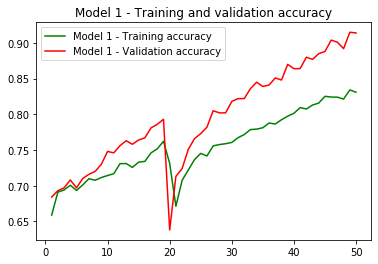

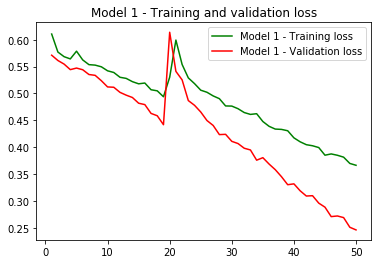

In [15]:
"""
Code below plots the resutls from the training using the matplot.
"""

acc = model_1_train.history['acc']
val_acc = model_1_train.history['val_acc']
loss = model_1_train.history['loss']
val_loss = model_1_train.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Model 1 - Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Model 1 - Validation accuracy')
plt.title('Model 1 - Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Model 1 - Training loss')
plt.plot(epochs, val_loss, 'r', label='Model 1 - Validation loss')
plt.title('Model 1 - Training and validation loss')
plt.legend()

plt.show()

In [16]:
"""
Code below is uesd for training the model-2.
"""

model_2_train = model_2.fit([X, X_cntx], Y, epochs = 20, batch_size=batch_size, 
            validation_data=([X_test, X_cntx_test], Y_test), verbose = 2)

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
 - 334s - loss: 0.5972 - accuracy: 0.6782 - val_loss: 0.5614 - val_accuracy: 0.7020
Epoch 2/20
 - 325s - loss: 0.5555 - accuracy: 0.7030 - val_loss: 0.5475 - val_accuracy: 0.7050
Epoch 3/20
 - 313s - loss: 0.5473 - accuracy: 0.7084 - val_loss: 0.5290 - val_accuracy: 0.7200
Epoch 4/20
 - 312s - loss: 0.5721 - accuracy: 0.6912 - val_loss: 0.5397 - val_accuracy: 0.7170
Epoch 5/20
 - 311s - loss: 0.5498 - accuracy: 0.7030 - val_loss: 0.5320 - val_accuracy: 0.7130
Epoch 6/20
 - 312s - loss: 0.5415 - accuracy: 0.7146 - val_loss: 0.5231 - val_accuracy: 0.7280
Epoch 7/20
 - 312s - loss: 0.5333 - accuracy: 0.7192 - val_loss: 0.5253 - val_accuracy: 0.7350
Epoch 8/20
 - 312s - loss: 0.5287 - accuracy: 0.7194 - val_loss: 0.5122 - val_accuracy: 0.7380
Epoch 9/20
 - 311s - loss: 0.5224 - accuracy: 0.7296 - val_loss: 0.5382 - val_accuracy: 0.7150
Epoch 10/20
 - 310s - loss: 0.5177 - accuracy: 0.7376 - val_loss: 0.4977 - val_accuracy: 0.7720
E

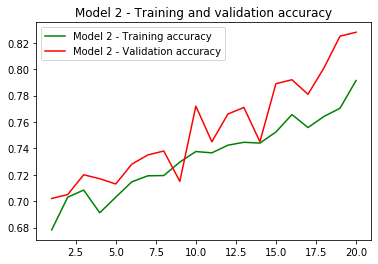

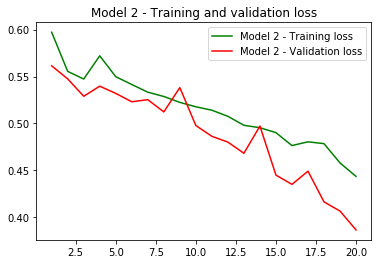

In [17]:
"""
Code below plots the resutls from the training using the matplot.
"""

acc = model_2_train.history['accuracy']
val_acc = model_2_train.history['val_accuracy']
loss = model_2_train.history['loss']
val_loss = model_2_train.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Model 2 - Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Model 2 - Validation accuracy')
plt.title('Model 2 - Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Model 2 - Training loss')
plt.plot(epochs, val_loss, 'r', label='Model 2 - Validation loss')
plt.title('Model 2 - Training and validation loss')
plt.legend()

plt.show()

In [18]:
"""
Code below is now used for preparing the "test" data-set for prediction. This builds the vector for test dataset
as we did for the training data-set.
"""

Z = tokenizer.texts_to_sequences(pred_data['response'].values)
Z = pad_sequences(Z, vec_len)
Z_cntx = tokenizer.texts_to_sequences(pred_data['cntx'].values)
Z_cntx = pad_sequences(Z_cntx, 250)

print(len(Z))
print(len(Z[0]))


1800
200


In [19]:
"""
Code below predicts the restuls for test data set using model_1 and model_2
"""
Z_label = model_1.predict(Z)
Z_cntx_label = model_2.predict([Z, Z_cntx])

In [20]:
"""
Code below combines the results from model_1 and model_2 and labes the data into SARCASM or NOT_SARCASM using threashold.
Note that I am using threashold as 0.5 (range 0 to 2.0) instead of uisng 1.0 as threashold. This has imporved the 
scoring for me that's the reason of using 0.5 as threashold.
"""

pred_data["score"] = Z_label
pred_data["cntx_score"] = Z_cntx_label
pred_data["total_score"] = pred_data["score"] + pred_data["cntx_score"]

pred_data['pred'] =pred_data["total_score"].apply(lambda x: 'SARCASM' if (x >= 0.5) else 'NOT_SARCASM')

In [21]:
"""
Finally code below is used exporting the predicted data into "answer.txt" file.
"""

export_data = pred_data[["id", "pred"]]
export_data.to_csv(path_or_buf='./answer.txt', sep=',',index=False)